In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

import utils

In [62]:
connections = pd.read_csv('./data/conexoes_espec.csv', sep=';')
individual = pd.read_csv('./data/individuos_espec.csv', sep=';')

df = connections.copy()
df = df[~df['prob_V1_V2'].isnull()]

In [63]:
# Missing Values

In [64]:
individual.isna().sum()

name                              0
idade                         95937
estado_civil                  50073
qt_filhos                     28867
estuda                        40130
trabalha                       6353
pratica_esportes             149124
transporte_mais_utilizado     43033
IMC                          113870
dtype: int64

Text(0.5, 1.0, '% of Missings por Variavel')

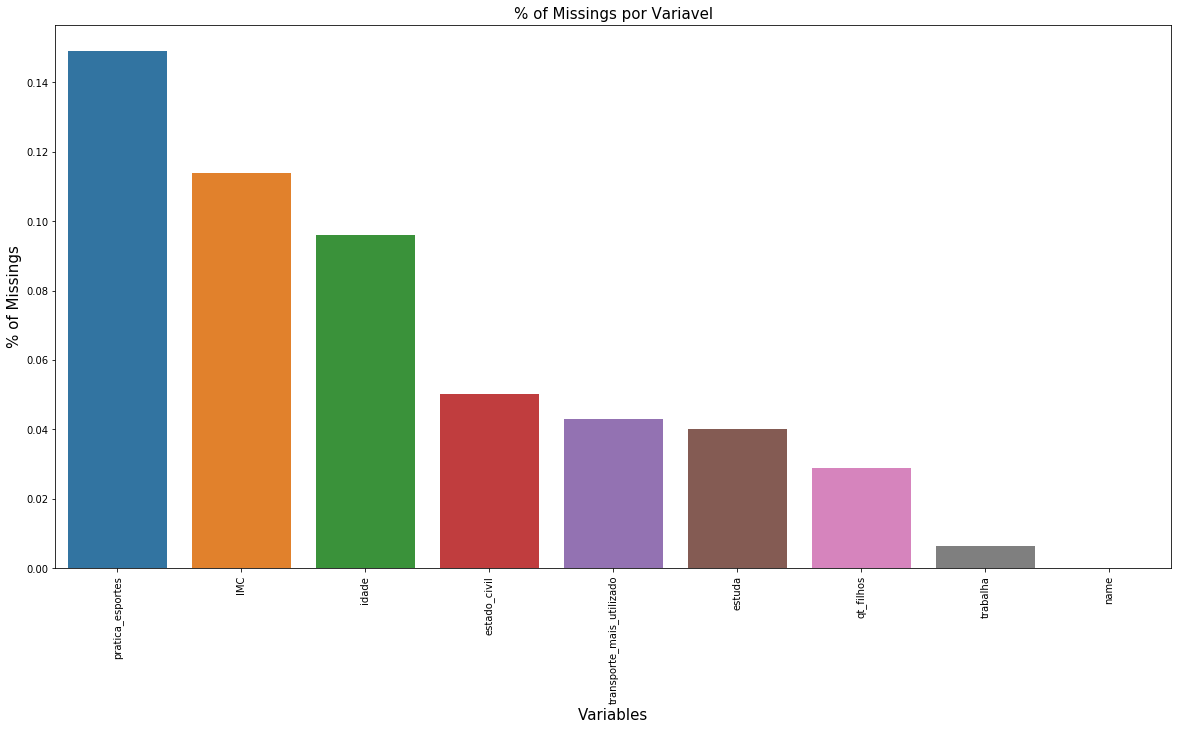

In [65]:
prop_missings = (individual.isna().sum().sort_values(ascending = False)/individual.shape[0])
f, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation = '90')
sns.barplot(x = prop_missings.index, y = prop_missings)
plt.xlabel('Variables', fontsize = 15)
plt.ylabel('% of Missings', fontsize = 15)
plt.title('% of Missings por Variavel', fontsize = 15)

Existem muitas categorias dentro de "qt_filhos". Cerca de 40% são de pessoas que não tem filhos. Vamos recodar.

In [66]:
individual['qt_filhos'].value_counts()

0.0    401401
1.0    331186
2.0    166111
3.0     55410
4.0     13770
5.0      2716
6.0       476
7.0        53
8.0         9
9.0         1
Name: qt_filhos, dtype: int64

Agora a variável possui três categorias: Se tem filhos, se não tem, e os missings tratados como "sem_info".

In [67]:
individual['filhos_status'] = np.where(individual['qt_filhos']==0, 'sem_filhos',
                               np.where(individual['qt_filhos']>0, 'filhos', 'sem_info_filhos'))

individual.drop('qt_filhos', axis=1, inplace=True) 

"Transporte", "Estado Civil", "Trabalha" e "Estuda" são variáveis categóricas binárias. Portanto, podemos trata-las da mesma maneira que a variável filhos acima, para evitarmos perder informação.

In [68]:
#to_fillna = individual.select_dtypes(include='object').columns

#for column in to_fillna:
#    individual[column].fillna('sem_info_' + column, inplace=True)

In [69]:
#individual['estuda'] = np.where(individual['estuda']==0, 'nao_estuda',
#                               np.where(individual['estuda']==1, 'estuda', 'sem_info_estuda'))

#individual['trabalha'] = np.where(individual['trabalha']==0, 'nao_trabalha',
#                               np.where(individual['trabalha']==1, 'trabalha', 'sem_info_trabalha'))

#individual['pratica_esportes'] = np.where(individual['pratica_esportes']==0, 'nao_pratica_esportes',
#                               np.where(individual['pratica_esportes']==1, 'pratica_esportes', 'sem_info_pratica_esportes'))

In [70]:
# Outliers

In [71]:
individual.dropna(subset=['IMC', 'idade'],inplace=True)
individual['z_IMC'] = np.abs(stats.zscore(individual['IMC']))
individual['z_idade'] = np.abs(stats.zscore(individual['idade']))
df['z_prob_V1_V2'] = np.abs(stats.zscore(df['prob_V1_V2']))



In [72]:
individual = individual[(individual['z_IMC']<3) & (individual['z_IMC']>-3)]
individual = individual[(individual['z_idade']<3) & (individual['z_idade']>-3)]

df = df[(df['z_prob_V1_V2']<3) & (df['z_prob_V1_V2']>-3)]

In [73]:
individual.drop(['z_IMC', 'z_idade'], axis=1, inplace=True)

In [74]:
individual['IMC'].describe().round(3)

count    787373.000
mean         22.201
std           6.564
min           4.853
25%          17.378
50%          21.351
75%          26.187
max          43.703
Name: IMC, dtype: float64

In [75]:
""" 
Coeficiente de Corr. de Pearson entre Idade e IMC resulta num valor praticamente nulo, 
apontando para não correlação linear entre ambas

""" 
corr = stats.pearsonr(individual['idade'], individual['IMC'])[0].round(4)
print('Coeficiente de Correlação de Pearson entre idade e IMC: {}'.format(corr))

Coeficiente de Correlação de Pearson entre idade e IMC: -0.0


In [76]:
# Mesclando Datasets

In [77]:
ind_V1 = individual.copy()
ind_V2 = individual.copy()

to_categorize = individual.select_dtypes(include='object')

ind_V1 = utils.rename_category(ind_V1, to_categorize, '_V1')
ind_V2 = utils.rename_category(ind_V2, to_categorize, '_V2')

In [78]:
ind_V1.columns = [str(col) + '_V1' for col in ind_V1.columns]
ind_V2.columns = [str(col) + '_V2' for col in ind_V2.columns]

In [79]:
ind_V1['V1'] = ind_V1['name_V1']
ind_V2['V2'] = ind_V2['name_V2']

ind_V1.drop('name_V1', axis=1, inplace=True)
ind_V2.drop('name_V2', axis=1, inplace=True)

In [80]:
df = df.merge(ind_V1, on='V1', how='left')
df = df.merge(ind_V2, on='V2', how='left')

In [81]:
to_dummy = df.select_dtypes(include='object')
df = utils.one_hot_encoder(df, to_dummy)
df.dropna(inplace=True)

In [82]:
# Escalar idade e IMC
to_scaler = ['idade_V1','idade_V2','IMC_V1','IMC_V2']
data_scaled = StandardScaler().fit_transform(df[to_scaler].values) 
scaled_features_df = pd.DataFrame(data_scaled, index=df[to_scaler].index, columns=df[to_scaler].columns)

df = pd.concat([df.drop(to_scaler, axis=1), scaled_features_df], axis=1)

In [83]:
to_drop_ld = ['amigos', 'visita_frequente', 'casado_V1',
              'taxi_V1', 'casado_V2', 'taxi_V2',
             'sem_info_filhos_V1','sem_info_filhos_V2',
             ]

df.drop(to_drop_ld, axis=1, inplace=True)

In [84]:
X = df.drop(['V1', 'V2', 'prob_V1_V2'], axis=1)
y = df['prob_V1_V2']

In [85]:
df.shape

(168521, 33)

In [86]:
df.columns

Index(['V1', 'V2', 'prob_V1_V2', 'z_prob_V1_V2', 'estuda_V1', 'trabalha_V1',
       'pratica_esportes_V1', 'estuda_V2', 'trabalha_V2',
       'pratica_esportes_V2', 'familia', 'trabalho', 'mora_junto',
       'visita_casual', 'visita_rara', 'divorciado_V1', 'solteiro_V1',
       'viuvo_V1', 'particular_V1', 'publico_V1', 'filhos_V1', 'sem_filhos_V1',
       'divorciado_V2', 'solteiro_V2', 'viuvo_V2', 'particular_V2',
       'publico_V2', 'filhos_V2', 'sem_filhos_V2', 'idade_V1', 'idade_V2',
       'IMC_V1', 'IMC_V2'],
      dtype='object')

In [87]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [88]:

ridge = Ridge(alpha=0.03)
ridge.fit(X_train,y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)


mean = mean_squared_error(y_test, y_test_pred) 
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [89]:
ridge_rmse

# 0.11093615575751926 Original
# 0.1109361471131281 Deixando LI
# 0.11069279363060261 Retirando Outliers Alpha = 0.1
# 0.11002705717976403 Filhos Categorizados

0.11002705717976403

In [91]:
def rmse_cv(model, cv):
    
    """
    Retorna o RMSE dos Dataset de teste e treino.
    
    model: Objeto do modelo treinado.
    cv: Número 'k' de K-Fold Cross-Validation
    
    """
    
    scorer = make_scorer(mean_squared_error, greater_is_better = False)     
    rmse_train = np.sqrt(-cross_val_score(model, X_train,
                                          y_train, scoring = scorer, cv = cv)) # Calcula o RMSE do dataset de treino.    
    rmse_test = np.sqrt(-cross_val_score(model, X_test,
                                         y_test, scoring = scorer, cv = cv)) # Calcula o RMSE do dataset de teste.
    
    return(print("RMSE do Dataset de Treino :", rmse_train.mean(),"\n" "RMSE do Dataset de Teste :", rmse_test.mean()))

In [92]:
rmse_cv(ridge, 10)

RMSE do Dataset de Treino : 0.11068567940457039 
RMSE do Dataset de Teste : 0.11004130474506013


In [93]:
print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_test_pred))))

Root Mean Square Error train = 0.1106534300995298
Root Mean Square Error test = 0.11002705717976403


Ridge picked 30 features and eliminated the other 0 features


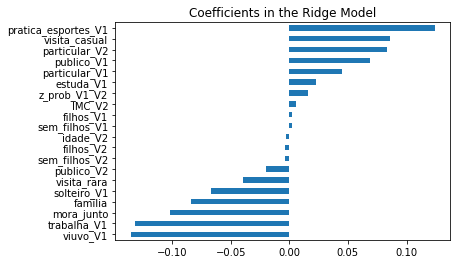

In [94]:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [95]:
# variance score: 1 means perfect prediction 
print('Variance score: {}'.format(ridge.score(X_test, y_test))) 

Variance score: 0.5961872568146878
